In [47]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D 
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

In [56]:
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # print(trainX.shape,trainY.shape,testX.shape,testY.shape)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # print(trainX.shape,trainY.shape,testX.shape,testY.shape)
    return trainX, trainY, testX, testY

In [13]:
load_dataset()
print("")

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)



In [42]:
def normalize_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

In [55]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [54]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    cur_fold=0
    for train_ix, test_ix in kfold.split(dataX):
        cur_fold+=1
        print(">> On fold "+str(cur_fold))
        model = create_model()
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        model.save("cnn_model_fold"+str(cur_fold)+".h5")
        print('>> %.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [61]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['acc'], color='blue', label='train')
        plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()

In [38]:
# summarize model performance
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

> Loading Dataset
> Normalizing pixels
> Training and evaluating model
>> On fold 1
>> 98.625
>> On fold 2
>> 98.558
>> On fold 3
>> 98.367
>> On fold 4
>> 98.817
>> On fold 5
>> 98.742


/mnt/G/handwritten-digit-recognition/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/mnt/G/handwritten-digit-recognition/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


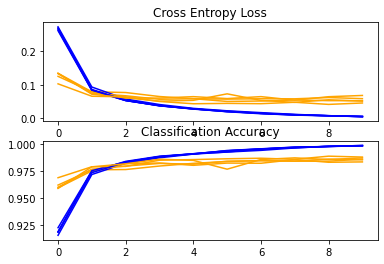

Accuracy: mean=98.622 std=0.156, n=5


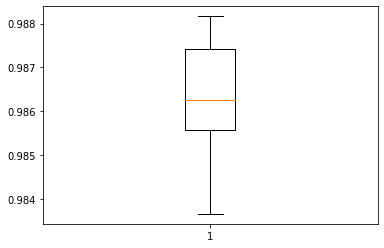

In [63]:
# run the test harness for evaluating a model
# def run_training():
# load dataset
print("> Loading Dataset")
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
print("> Normalizing pixels")
trainX, testX = normalize_pixels(trainX, testX)
# evaluate model
print("> Training and evaluating model")
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)